<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/Text_Embeddings_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import shutil
import sys
import zipfile
import gensim
import re

# Document / Text Clustering using Word Embeddings
In this notebook I will be running a text clustering model on data taken from the National Gallery of Art.

## Data Loading

In [2]:
# unpacking art_tables.zip using zipfile library and then load the two csv's (latinamerican_art.csv & non_latinamerican_art.csv)
# into a single dataframe
nga_art_sample = None
with zipfile.ZipFile('./data_samples/art_tables.zip', 'r') as zip_ref:
    zip_ref.extractall('./data_samples/')
    for file in zip_ref.namelist():
        if file.endswith('.csv'):
            # only sampling 628 rows from non_latinamerican.csv file & all from latinamerican, and selecting only title and nationality
            # latinamerican has very few rows so we are sampling all of them
            to_sample = True if 'non_latinamerican' in file else False
            if nga_art_sample is None:
                if to_sample:
                    nga_art_sample = pd.read_csv('./data_samples/' + file, on_bad_lines='skip').loc[:, ['title', 'nationality']].sample(628)
                else:
                    nga_art_sample = pd.read_csv('./data_samples/' + file, on_bad_lines='skip').loc[:, ['title', 'nationality']]
            else:
                if to_sample:
                    nga_art_sample = pd.concat([pd.read_csv('./data_samples/' + file, on_bad_lines='skip').loc[:, ['title', 'nationality']].sample(628), nga_art_sample])
                else:
                    nga_art_sample = pd.concat([pd.read_csv('./data_samples/' + file, on_bad_lines='skip').loc[:, ['title', 'nationality']], nga_art_sample])
# delete the unzipped data directory
shutil.rmtree('./data_samples/art_tables')

print(nga_art_sample.shape)
nga_art_sample.head()


(1256, 2)


<ipython-input-2-db2966cc6825>:18: DtypeWarning: Columns (2,10,11,14,15,16,17,24,25,32,33,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  nga_art_sample = pd.concat([pd.read_csv('./data_samples/' + file, on_bad_lines='skip').loc[:, ['title', 'nationality']].sample(628), nga_art_sample])


,title,nationality
15088,Chalice of the Abbot Suger of Saint-Denis,NaN
123195,"Seated Nude Turned to the Right, Arms Resting ...",American
141534,"The Dining Room, Stenton",American
197406,Lamp,American
82560,Auch ein Todtentanz IV,German


In [3]:
nga_art_sample.columns

Index(['title', 'nationality'], dtype='object')

## Data Processing

For data processing, I will be cleaning the data to remove obvious errors in the title and nationality columns such as missing values that coul've occured during the sampling and extraction step (data was originally stored in a Mysql database).

And for feature engineering, in order to prepare for document clustering and text embedding I will be calculating the TF-IDF and n-grams of the titles by using Word2Vec.

In [4]:
# we can see that titles and nationality differ in number of rows, so we will drop rows with missing values
# we can also see that top title is 'Untitled' which is not very useful for our analysis, so we will drop those rows as well
# finally, we can see that top nationality is 'Mexican' so we will need to include spanish stopwords in our list
nga_art_sample.describe()

,title,nationality
count,1256,1250
unique,850,34
top,Untitled,Mexican
freq,51,374


In [5]:
# dropping null values and 'Untitled' titles
nga_art_sample = nga_art_sample.dropna()
nga_art_sample = nga_art_sample[nga_art_sample.title != 'Untitled']
nga_art_sample.describe()

,title,nationality
count,1199,1199
unique,843,34
top,Garden,Mexican
freq,36,368


In [6]:
# remove non-ascii characters from titles
nga_art_sample.title = nga_art_sample.title.str.encode('ascii', 'ignore').str.decode('ascii')
# remove non-word characters from titles, including parentheses & quotation marks
nga_art_sample.title = nga_art_sample.title.str.replace(r"[\"':;,!?\\/\-+&=]|(\(.*\))", "", regex=True)
nga_art_sample.title = nga_art_sample.title.str.strip()
nga_art_sample.title = nga_art_sample.title.str.lower()

In [7]:
nga_art_sample.head()

,title,nationality
123195,seated nude turned to the right arms resting o...,American
141534,the dining room stenton,American
197406,lamp,American
82560,auch ein todtentanz iv,German
87981,untitled,American


## Feature Engineering

In [8]:
from gensim.models.phrases import Phrases

# Convert the titles to a list of lists of words
title_words = [title.split() for title in nga_art_sample['title']]

# Create bigrams
bigram = Phrases(title_words, min_count=1, threshold=1)

# Apply the bigram model to the titles
title_bigrams = [bigram[title] for title in title_words]

In [9]:
title_words[:5]

[['seated',
  'nude',
  'turned',
  'to',
  'the',
  'right',
  'arms',
  'resting',
  'on',
  'thighs'],
 ['the', 'dining', 'room', 'stenton'],
 ['lamp'],
 ['auch', 'ein', 'todtentanz', 'iv'],
 ['untitled']]

### TF-IDF Matrix

In [10]:
# calculaing the tf-idf matrix of bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_bigram = TfidfVectorizer(ngram_range=(2,2))
vectors = vectorizer_bigram.fit_transform([' '.join(title) for title in title_bigrams])
#create a dataframe of the vectors
title_bigram_df = pd.DataFrame(vectors.toarray(), columns=vectorizer_bigram.get_feature_names_out())
title_bigram_df.head()

,09 trial_proof,11th_street story,12 12,12 proof,12 rue,14451496 lord,14631494 philosopher,14721532 obverse,1478 obverse,15601641 civil,...,yosemite nationa,yosemite valley,you_dont see,young girl,young tuxedo,young woman_and,young_man glancing,yvonne in,zur quelle,zwei mnner
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
title_bigram_df.describe()

,09 trial_proof,11th_street story,12 12,12 proof,12 rue,14451496 lord,14631494 philosopher,14721532 obverse,1478 obverse,15601641 civil,...,yosemite nationa,yosemite valley,you_dont see,young girl,young tuxedo,young woman_and,young_man glancing,yvonne in,zur quelle,zwei mnner
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,...,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,0.000590,0.000765,0.000482,0.000340,0.000590,0.000241,0.000315,0.000373,0.000241,0.000315,...,0.000315,0.000373,0.000765,0.000834,0.000344,0.000417,0.000373,0.000590,0.000482,0.000340
std,0.020421,0.018765,0.016674,0.011790,0.020421,0.008337,0.010915,0.012915,0.008337,0.010915,...,0.010915,0.012915,0.018765,0.028880,0.011896,0.014440,0.012915,0.020421,0.016674,0.011790
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.707107,0.485717,0.577350,0.408248,0.707107,0.288675,0.377964,0.447214,0.288675,0.377964,...,0.377964,0.447214,0.485717,1.000000,0.411925,0.500000,0.447214,0.707107,0.577350,0.408248


## Model

### K-Means Clustering
Now that we have the title-bigrams, we can generate a cosine similarity matrix which will model each individual 'document'/'title' in the title_bigram_df into a representation that can be used to compare the similarity of each 'title' to every other 'title'.

In [12]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(title_bigram_df)
clusters = km.labels_.tolist()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
len(clusters)

1199

In [18]:
nga_art_sample.reset_index(drop='False', inplace=True)

In [19]:
title_bigram_df['title'] = nga_art_sample.title
title_bigram_df['cluster'] = clusters

## Visualize Clusters using a Word Cloud of the Titles
Clusters found by K-Means on the TF-IDF Matrix can be visualized using a Word cloud.

In [24]:
# importing a library to create a word cloud

from wordcloud import WordCloud


In [22]:
generated_clusters = title_bigram_df.loc[:, ['title', 'cluster']]

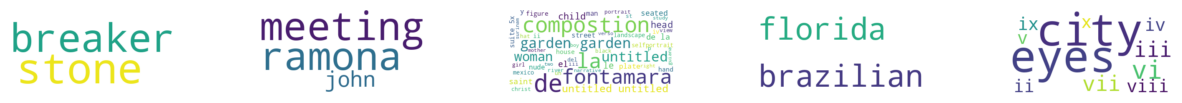

In [25]:
# grouping the pandas generated_clusters dataframe using the cluster column
# and then create a word cloud of the title column for each in a grid using matplotlib and wordcloud's WordCloud library package

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for cluster in generated_clusters.cluster.unique():
    plt.subplot(5, 5, cluster + 1)
    wc = WordCloud(background_color="white", max_words=50)
    wc.generate(" ".join(generated_clusters[generated_clusters.cluster == cluster].title))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
plt.show()
